# Modeling elections

In [38]:
from scipy import stats as sts
import numpy as np
import matplotlib.pyplot as plt
import pystan

## Data

The `electoral_votes` variable is a dictionary containing the number of Electoral College votes for each state. For example
```
  >>> electoral_votes['Indiana']
  11
```
Data from [Wikipedia: United_States_Electoral_College](https://en.wikipedia.org/wiki/United_States_Electoral_College)

The `survey_results` variable is a dictionary mapping from states to an array of survey results for each candidate. Each row in a survey results array represents one survey and each column represents one candidate. There are 4 columns, representing Clinton, Trump, Johnson, and Stein in that order. In the example below, Clinton got 340 votes in the first survey, Trump got 258, Johnson got 27, and Stein got 13.
```
  >>> survey_results['Indiana']
  array([[340, 258,  27,  13],
         [240, 155,   5,   5],
         [235, 155,  50,  20],
         [308, 266,  49,  35],
         [222, 161,  80,  30]])
```
Data from [Wikipedia: Statewide opinion polling for the United States presidential election, 2016](https://en.wikipedia.org/wiki/Statewide_opinion_polling_for_the_United_States_presidential_election,_2016)


In [2]:
electoral_votes = {
    'Alabama': 9,
    'Alaska': 3,
    'Arizona': 11,
    'Arkansas': 6,
    'Colorado': 9,
}

survey_results = {
    'Alabama': np.array([], dtype=int).reshape(0, 4),
    'Alaska': np.array([400 * np.array([.47, .43, .07, .03]), 500 * np.array([.36, .37, .07, .03]), 500 * np.array([.34, .37, .10, .02]), 660 * np.array([.31, .36, .18, .06])], dtype=int),
    'Arizona': np.array([392 * np.array([.45, .47, .05, .02]), 550 * np.array([.39, .47, .04, .03]), 719 * np.array([.40, .45, .09, .03]), 769 * np.array([.44, .49, .05, .01]), 2229 * np.array([.45, .44, .07, .01]), 700 * np.array([.43, .47, .02, .02]), 550 * np.array([.41, .45, .03, .01]), 994 * np.array([.42, .44, .04, .01]), 550 * np.array([.40, .42, .05, .02]), 2385 * np.array([.48, .46, .05, .01]), 401 * np.array([.45, .46, .04, .01]), 550 * np.array([.41, .41, .05, .02]), 1538 * np.array([.39, .44, .06, .02]), 713 * np.array([.43, .38, .06, .01]), 400 * np.array([.39, .37, .08, .03]), 600 * np.array([.44, .42, .09, .01]), 718 * np.array([.42, .42, .05, .01]), 484 * np.array([.41, .46, .09, .01]), 649 * np.array([.38, .40, .12, .03])], dtype=int),
    'Arkansas': np.array([463 * np.array([.33, .56, .04, .02]), 831 * np.array([.34, .55, .03, .01]), 600 * np.array([.29, .57, .05, .03])], dtype=int),
    'Colorado': np.array([1150 * np.array([.45, .44, .05, .04]), 500 * np.array([.44, .38, .07, .02]), 550 * np.array([.39, .39, .05, .04]), 750 * np.array([.44, .41, .08, .04]), 685 * np.array([.45, .37, .10, .03]), 400 * np.array([.49, .38, .07, .03]), 602 * np.array([.44, .33, .10, .03]), 694 * np.array([.46, .40, .06, .02]), 784 * np.array([.41, .42, .13, .03]), 991 * np.array([.40, .39, .07, .02]), 644 * np.array([.44, .42, .10, .02]), 540 * np.array([.41, .34, .12, .03]), 600 * np.array([.38, .42, .13, .02]), 704 * np.array([.48, .43, .04, .02]), 605 * np.array([.43, .38, .07, .02]), 997 * np.array([.42, .39, .07, .02])], dtype=int),
}

states = sorted(survey_results.keys())
print('Modeling', len(states), 'states with', sum(electoral_votes[s] for s in states), 'electoral college votes')

Modeling 5 states with 38 electoral college votes


In [7]:
survey_results['Alaska']

array([[188, 172,  28,  12],
       [180, 185,  35,  15],
       [170, 185,  50,  10],
       [204, 237, 118,  39]])

## Generative model

1. For each state we generate an $\vec{\alpha}$ vector, which defines a Dirichlet distribution over the proportion of votes that go to each of the 4 candidates whenever we do a survey — including the final survey, namely the election itself which we want to predict. The prior over each component of $\vec{\alpha}$ is taken as a Cauchy distribution with location 0 and scale 1. Since the components of $\vec{\alpha}$ are positive, we actually use the positive half-Cauchy distribution.

2. For each survey in a state we generate a probability vector $\vec{p_i} \sim \text{Dirichlet}(\vec{\alpha})$ for the probability that a voter selects each of the 4 candidates.

3. For each survey, we then generate the number of votes going to each candidate as $\vec{k_i} \sim \text{Multinomial}(\vec{p_i})$.

### Tasks

* Use Stan to sample from the posterior distribution over $\alpha$ and visualize your results. There are 10 states, so you will have 10 posteriors.
* The posteriors over $\alpha$ show a lot of variation between different states. Explain the results you get in terms of the model and the data.

In [73]:
stan_code = '''
data {
    int<lower=0> S;    // number of surveys
    int<lower=1> C;    // number of categories in the multinomial
    int counts[S,C];     // <- the data set: counts for each category
}

parameters {
    simplex[C] theta[S];  // the probability vector over categories
    vector[C] alpha;
}

model {
    alpha ~ cauchy(0, 1);
    for (i in 1:S) {
        theta[i] ~ dirichlet(alpha);
        counts[i] ~ multinomial(theta[i]);
    }
    
}
'''

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_517986e76ffc85085cad1acc570345b5 NOW.


In [79]:
#input is numpy array
def get_results(state_survey_results):
    state_data = {
        'S': len(state_survey_results),
        'C': 4,
        'counts': state_survey_results
    }
    results = stan_model.sampling(data=state_data)
    return results

alaska_results = get_results(survey_results['Alaska'])
arizona_results = get_results(survey_results['Arizona'])
arkansas_results = get_results(survey_results['Arkansas'])
colorado_results = get_results(survey_results['Colorado'])

In [106]:
def plot_figure(results):
    samples = results.extract()
    plt.figure(figsize=(12, 6))
    for i in range(4):
        plt.plot(sts.uniform.rvs(loc=i+1-0.1, scale=0.2, size=samples['alpha'].shape[0]), samples['alpha'][:,i], ',', alpha=0.5)
    plt.title('Distribution over each component of alpha')
    plt.show()

Inference for Stan model: anon_model_517986e76ffc85085cad1acc570345b5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
alpha[1]   13.4    0.39    8.5   3.03  35.61    465   1.01
alpha[2]  13.94     0.4   8.81    3.0  37.09    474   1.01
alpha[3]   3.76    0.11   2.39   0.86  10.26    506   1.01
alpha[4]   1.53    0.04   0.89   0.43    3.8    611   1.01

Samples were drawn using NUTS at Tue Oct 23 11:45:22 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


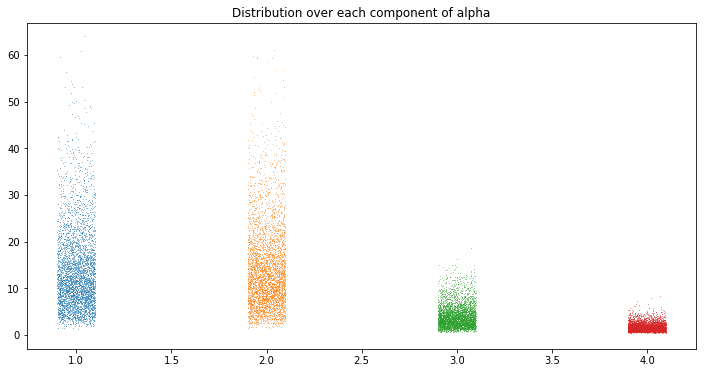

In [117]:
print(alaska_results.stansummary(pars='alpha',probs=(0.025, 0.975)))
plot_figure(alaska_results)

Inference for Stan model: anon_model_517986e76ffc85085cad1acc570345b5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
alpha[1]   88.4    0.87  24.68  50.01 144.34    804   1.01
alpha[2]  92.04    0.88  25.74  52.01 150.01    846   1.01
alpha[3]  12.03    0.12   3.44   6.73  19.74    787   1.01
alpha[4]    3.5    0.03   0.97   1.97   5.67    935   1.01

Samples were drawn using NUTS at Tue Oct 23 11:45:32 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


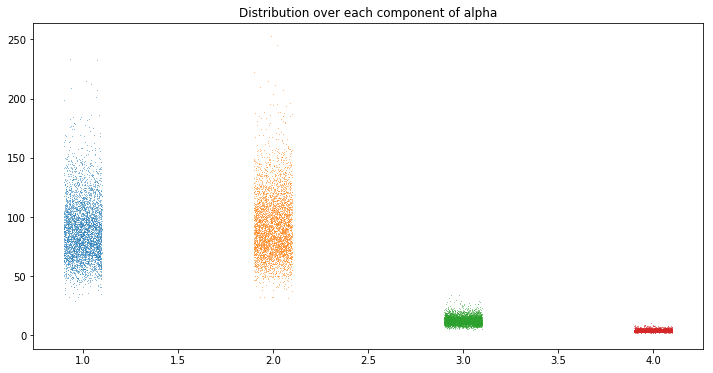

In [118]:
print(arizona_results.stansummary(pars='alpha',probs=(0.025, 0.975)))
plot_figure(arizona_results)

Inference for Stan model: anon_model_517986e76ffc85085cad1acc570345b5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
alpha[1]  21.13    1.11  19.98   2.75   71.9    327   1.01
alpha[2]  36.89    1.92  34.42   4.85 123.65    322   1.01
alpha[3]   2.74    0.13   2.38   0.49   9.03    344   1.01
alpha[4]   1.49    0.06   1.13   0.31    4.6    364   1.01

Samples were drawn using NUTS at Tue Oct 23 11:45:34 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


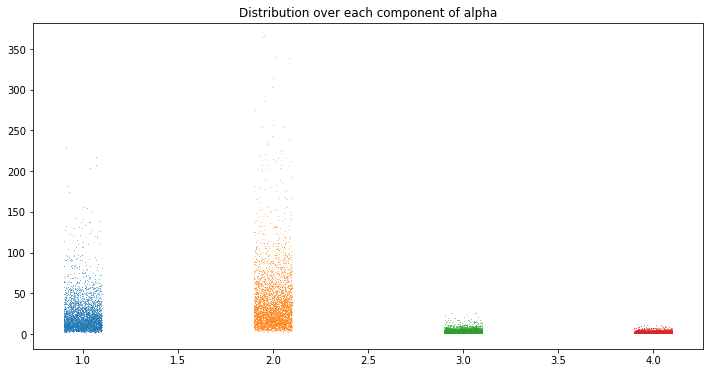

In [119]:
print(arkansas_results.stansummary(pars='alpha',probs=(0.025, 0.975)))
plot_figure(arkansas_results)

Inference for Stan model: anon_model_517986e76ffc85085cad1acc570345b5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
alpha[1]  90.36    1.05  28.21  47.39 158.64    729    1.0
alpha[2]  82.26    0.96  25.72  43.02 143.11    714    1.0
alpha[3]  16.59    0.19   5.23   8.68  29.26    736    1.0
alpha[4]   5.72    0.06   1.79   3.01  10.01    815    1.0

Samples were drawn using NUTS at Tue Oct 23 11:45:42 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


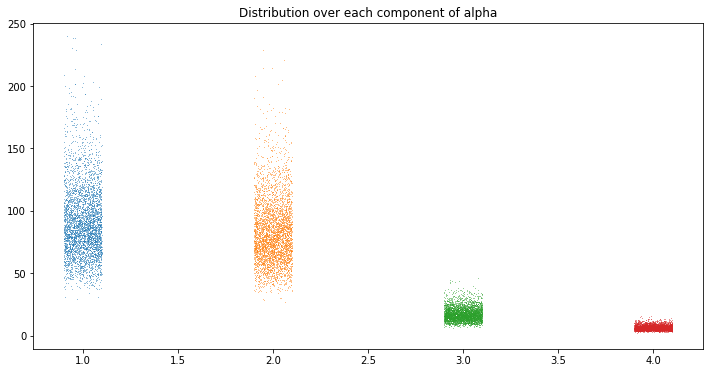

In [120]:
print(colorado_results.stansummary(pars='alpha',probs=(0.025, 0.975)))
plot_figure(colorado_results)

## Simulation time

Use the posterior samples to predict the outcome of the presidential elections.

* Predict the probability that each candidate will win each state.
   * Use the posterior $\alpha$ samples to generate posterior predictive samples for $p$ — the proportion of votes each candidate would get in each state in an election.
   * Use these $p$ samples to estimate the probability that each candidate will win each state.
* Predict the probability that each candidate will win the presidential election.
   * Use the posterior predictive probability that each candidate will win each state to generate samples over the total number Electoral College votes each candidate would get in an election.
   * Use the total number of votes to generate samples over who would win the election.

In [151]:
def get_posterior_predictive_samples(state_results):
    samples = state_results.extract()
    # Make a new array with same dimensions as alpha
    p_predicted = np.empty(samples['alpha'].shape)
    # Generate one p sample for each alpha sample
    for i in range(samples['alpha'].shape[0]):
        p_predicted[i] = stats.dirichlet(samples['alpha'][i]).rvs()
    return p_predicted

p_alaska = get_posterior_predictive_samples(alaska_results)
p_arizona = get_posterior_predictive_samples(arizona_results)
p_arkansas = get_posterior_predictive_samples(arkansas_results)
p_colorado = get_posterior_predictive_samples(colorado_results)

In [154]:
def posterior_prediction_results(posterior_samples):
    clinton = np.mean(posterior_samples[:,0])
    trump = np.mean(posterior_samples[:,1])
    johnson = np.mean(posterior_samples[:,2])
    stein = np.mean(posterior_samples[:,3])
    print("Clinton: {:.2f},\nTrump: {:.2f},\nJohnson: {:.2f},\nStein: {:.2f}".format(clinton,trump,johnson,stein))
    
print("Posterior prediction for Alaska results")
posterior_prediction_results(p_alaska)
print("\nPosterior prediction for Arizona results")
posterior_prediction_results(p_arizona)
print("\nPosterior prediction for Arkansas results")
posterior_prediction_results(p_arkansas)
print("\nPosterior prediction for Colorado results")
posterior_prediction_results(p_colorado)

Posterior prediction for Alaska results
Clinton: 0.41,
Trump: 0.42,
Johnson: 0.12,
Stein: 0.05

Posterior prediction for Arizona results
Clinton: 0.45,
Trump: 0.47,
Johnson: 0.06,
Stein: 0.02

Posterior prediction for Arkansas results
Clinton: 0.34,
Trump: 0.58,
Johnson: 0.05,
Stein: 0.03

Posterior prediction for Colorado results
Clinton: 0.46,
Trump: 0.42,
Johnson: 0.09,
Stein: 0.03


Trump wins Alaska, Arizona and Arkansas. Clinton wins Colorado.

Electoral College votes:

Trump: $3+11+6 = 20$

Clinton: $9$